# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.
Our target accuracy is 70%, but any accuracy over 50% is a great start.
Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [56]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import sys
from torchvision import models
from collections import OrderedDict
from torchvision import datasets
from IPython.display import clear_output

## Settings

In [57]:
# Setings
ROOT_DIR='./dataset'
BATCH_SIZE=64

# Set verbosity
VERBOSE=1

# Some getters to handle PyTorch versions
# I typically put this in 'helper.py'
def pytorch_version():
    """Returns the PyTorch version as a string"""
    return(torch.__version__)

def pytorch_major_version():
    """Returns the PyTorch major version as an integer"""
    vers_splits = pytorch_version().split(".")
    return(int(vers_splits[0]))

print(f"[INFO] The current PyTorch version is: {pytorch_version()}")

[INFO] The current PyTorch version is: 2.0.1+cpu


## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

### About the CIFAR-10 Dataset
The CIFAR-10 Dataset has a total of 60000 images of 10 different classes: Airplane, Automobile, Bird, Cat, Deer, Dog, Frog, Horse, Ship, Truck. All the images are of size 32×32 with 3 color channels per pixel (i.e. images are RGB color images). There are a total of 50,000 train images and 10,000 test images.

[CIFAR-10 INFO]
	 Dataset type is                   : <class 'numpy.ndarray'>
	 Dataset shape is                  : (50000, 32, 32, 3)
	 Number of datapoints              : 50000
	 Root location                     : ./dataset/cifar-10-batches-py
	 The mean of the RGB channels are  : [0.49139968 0.48215841 0.44653091]
	 The std dev ofthe RGB channels are: [0.24703223 0.24348513 0.26158784]
	 And this one of the images of the dataset. Can you see the truck? 


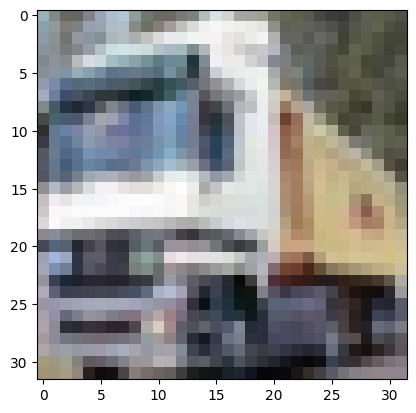

In [58]:
# Let's start downloading the dataset to take a look at it. We also need it to
# compute the mean and the standard deviation over the 3 RGB channels.
cifar10 = datasets.CIFAR10(ROOT_DIR, train=True,  download=True)

# Show me a few randomnly selected images
for i in range(1, 10):
    img, label = cifar10[random.randrange(len(cifar10))]
    plt.imshow(img)
    plt.show()
    time.sleep(0.25)
    clear_output(wait=True)
    
# Compute the mean and standard deviation of the RGB channels
if pytorch_major_version() < 1:
    data = cifar10.train_data / 255
else:
    data = cifar10.data / 255
cifar10_mean = data.mean(axis = (0, 1, 2)) 
cifar10_std  = data.std(axis = (0, 1, 2))
    
print(f"[CIFAR-10 INFO]")
if pytorch_major_version() < 1:
    print(f"\t Dataset type is                   : {type(cifar10.train_data)}")
    print(f"\t Dataset shape is                  : {cifar10.train_data.shape}")
else:
    print(f"\t Dataset type is                   : {type(cifar10.data)}")
    print(f"\t Dataset shape is                  : {cifar10.data.shape}")
print(f"\t Number of datapoints              : {len(cifar10)}")
print(f"\t Root location                     : {ROOT_DIR}/{cifar10.base_folder}")
print(f"\t The mean of the RGB channels are  : {cifar10_mean}")
print(f"\t The std dev ofthe RGB channels are: {cifar10_std}")
    
img, label = cifar10[1]  # Can you see the truck?     
print(f"\t And this one of the images of the dataset. Can you see the truck? ")
img, label = cifar10[1]
plt.imshow(img)

In [59]:
# Define a data transformation pipeline to preprocess the input data 
# before feeding it into a PyTorch model.
# We will start with the bare minimum required (i.e. w/o data augmentation)
# and namely:
#  - transforms.ToTensor() to convert the input images into PyTorch tensors
#    that can be processed by our model.
#  - transforms.Normalize((0.49, 0.48, 0.44), (0.25 0.24 0.26)) to normalize
#    the tensor values between 0 and 1. In this case, the mean and the 
#    standard deviation are computed over the 3 RGB channels (see above) or
#    are retrieved from the litterature. 
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(p=0.5),
                                       transforms.ToTensor(),
                                       transforms.Normalize(cifar10_mean,
                                                            cifar10_std)])

test_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize(cifar10_mean,
                                                           cifar10_std)])

# Load the dataset, create training and a validation sets, apply transforms
train_set = torchvision.datasets.CIFAR10(root=ROOT_DIR, train=True,
                                         download=True, transform=train_transforms)
test_set = torchvision.datasets.CIFAR10(root=ROOT_DIR, train=True,
                                         download=True, transform=test_transforms)

# Create training and validation dataloaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                           shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

# Define the 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 
           'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[INFO]
	This is an image of the class 'dog' 


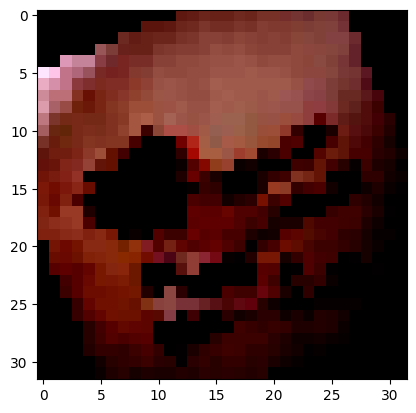

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[INFO]
	This is an image of the class 'truck' 


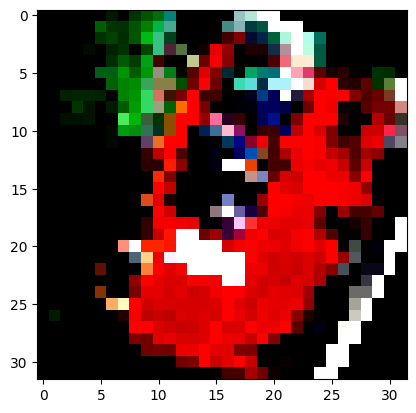

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[INFO]
	This is an image of the class 'plane' 


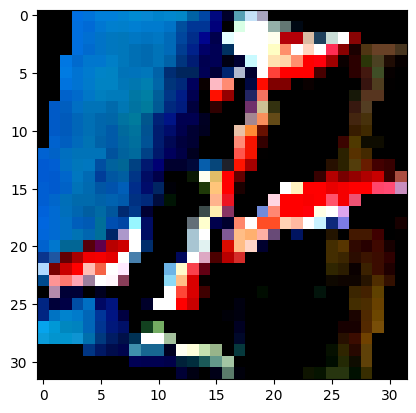

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[INFO]
	This is an image of the class 'car' 


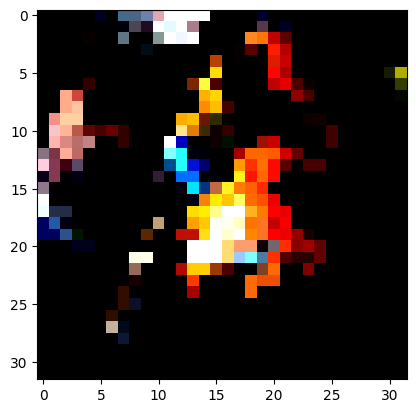

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[INFO]
	This is an image of the class 'dog' 


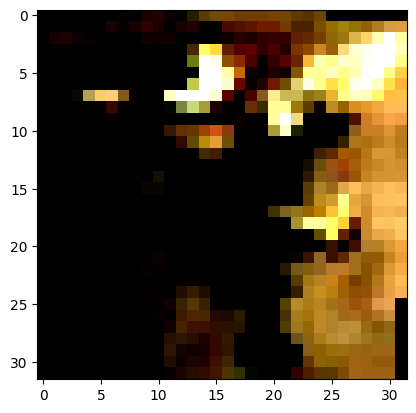

In [60]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(f"[INFO]\n\tThis is an image of the class \'{classes[labels[i]]}\' ")   
        image = images[i].numpy()
        plt.imshow(image.T)
        plt.show()
        
# Explore data
show5(train_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [61]:
nn_arch_list = ['my_lenet_arch', 'my_alex_arch', 'my_cnn_arch']

# Select the architecture of the model you want to build 
#  (Warning: The 'my_alex_arch' does not work yet)
nn_arch = nn_arch_list[0]

# Hyperparameters for our network
inp_size  = 32*32
out_size  = 10

# Create 'Flatten' layer for older version of PyTorch
if pytorch_major_version() < 1:
    class Flatten(nn.Module):
        def forward(self, input):
            return input.view(input.size(0), -1)

if nn_arch == 'my_lenet_arch':      

    # Define a feed-forward network architecture inspired by LeNet-5
    #  Note: [LeNet-5](https://blog.paperspace.com/writing-lenet5-from-scratch-in-python/) 
    #   architecture is a deep neural network that was proposed for 
    #   handwritten and machine-printed character recognition in 1998. 
    #   It consists of two sets of convolutional and average pooling layers,
    #   followed by a flattening convolutional layer, then two fully-connected
    #    layers and finally a softmax classifier.

    lenet_l1 = nn.Sequential(OrderedDict([
                ('c2d_1',  nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)),
                ('bn2d_1', nn.BatchNorm2d(6)),
                ('relu_1', nn.ReLU()),
                ('mp2d_1', nn.MaxPool2d(kernel_size=2, stride=2))
    ]))

    lenet_l2 = nn.Sequential(OrderedDict([
                ('c2d_2',  nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)),
                ('bn2d_2', nn.BatchNorm2d(16)),
                ('relu_2', nn.ReLU()),
                ('mp2d_2', nn.MaxPool2d(kernel_size=2, stride=2))   
    ]))

    if pytorch_major_version() < 1:
        model = nn.Sequential(OrderedDict([
                            ('l1',     lenet_l1),
                            ('l2',     lenet_l2),
                            ('fltn_1', Flatten()),
                            ('fc1',    nn.Linear(400, 120)),
                            ('relu_3', nn.ReLU()),
                            ('fc2',    nn.Linear(120, 84)),
                            ('relu_4', nn.ReLU()),
                            ('fc3',    nn.Linear(84, len(classes))),
                            ('lsf',    nn.LogSoftmax(dim=1))
        ]))
    else:
        model = nn.Sequential(OrderedDict([
                            ('l1',     lenet_l1),
                            ('l2',     lenet_l2),
                            ('fltn_1', nn.Flatten()),
                            ('fc1',    nn.Linear(400, 120)),
                            ('relu_3', nn.ReLU()),
                            ('fc2',    nn.Linear(120, 84)),
                            ('relu_4', nn.ReLU()),
                            ('fc3',    nn.Linear(84, len(classes))),
                            ('lsf',    nn.LogSoftmax(dim=1))
    ]))
elif nn_arch == 'my_alex_arch':
    # Define a feed-forward network architecture inspired by AlextNet
    #  Note: [AlexNet](https://medium.com/@siddheshb008/alexnet-architecture-explained-b6240c528bd5) 
    #   was introduced in 2012 to solve the ImageNet classification challenge.
    #   The NN architecture has a total of 8 layers which are further
    #   subdivided into 5 convolution layers and 3 fully connected layers. This 
    #   makes it simple enough to start playing with on our Laptop (hopefully).
    model = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(kernel_size=3, stride=2),
                        nn.Conv2d(64, 192, kernel_size=5, padding=2),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(kernel_size=3, stride=2),
                        nn.Conv2d(192, 384, kernel_size=3, padding=1),
                        nn.ReLU(inplace=True),
                        nn.Conv2d(384, 256, kernel_size=3, padding=1),
                        nn.ReLU(inplace=True),
                        nn.Conv2d(256, 256, kernel_size=3, padding=1),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(kernel_size=3, stride=2),
                        nn.LogSoftmax(dim=1)
    )
elif nn_arch == 'my_cnn_arch':
    # Define a custom feed-forward network inspired by Jay's project found on 
    # GitHub (https://github.com/jaycode/udacity-create-your-own-image-classifier/tree/main)
    if pytorch_major_version() < 1:
        model = nn.Sequential(
                    nn.Conv2d(3, 32, kernel_size=3, padding=1),
                    nn.ReLU(),
                    nn.MaxPool2d(2, 2),
                    nn.Dropout(0.2),
                    nn.Conv2d(32, 64, kernel_size=3, padding=1),
                    nn.ReLU(),
                    nn.MaxPool2d(2, 2),
                    nn.Dropout(0.2),
                    Flatten(),
                    nn.Linear(64*8*8, 128),
                    nn.ReLU(),
                    nn.Dropout(0.2),
                    nn.Linear(128, 64),
                    nn.ReLU(),
                    nn.Dropout(0.2),
                    nn.Linear(64, 10),
                    nn.LogSoftmax(dim=1)
        )
    else:
        model = nn.Sequential(
                    nn.Conv2d(3, 32, kernel_size=3, padding=1),
                    nn.ReLU(),
                    nn.MaxPool2d(2, 2),
                    nn.Dropout(0.2),
                    nn.Conv2d(32, 64, kernel_size=3, padding=1),
                    nn.ReLU(),
                    nn.MaxPool2d(2, 2),
                    nn.Dropout(0.2),
                    nn.Flatten(),
                    nn.Linear(64*8*8, 128),
                    nn.ReLU(),
                    nn.Dropout(0.2),
                    nn.Linear(128, 64),
                    nn.ReLU(),
                    nn.Dropout(0.2),
                    nn.Linear(64, 10),
                    nn.LogSoftmax(dim=1)
        )
else:
    print(f"ERROR: Unknown NN architecture \'{nn_arch}\' ")
    sys.exit()
    
# Print some information about the selected architecture 
print(f"Type of model is {type(model)} \n")

if nn_arch == 'my_lenet_model':
    print(f"[INFO] The architecture of our NN inspired by LeNet-5 is as follows: {model})")
elif nn_arch == 'my_alex_model':
    print(f"[INFO] The architecture of our NN inspired by AlexNet is as follows: {model})")
else:
    print(f"[INFO] The architecture of our custom NN is as follows: {model}")

Type of model is <class 'torch.nn.modules.container.Sequential'> 

[INFO] The architecture of our custom NN is as follows: Sequential(
  (l1): Sequential(
    (c2d_1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (bn2d_1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu_1): ReLU()
    (mp2d_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (l2): Sequential(
    (c2d_2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (bn2d_2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu_2): ReLU()
    (mp2d_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fltn_1): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (relu_3): ReLU()
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (relu_4): ReLU()
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (lsf): LogSoftmax(d

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [62]:
# Define a criterion and an optimizer
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [63]:
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training device is {device}")
model.to(device)

# Train the network here
epochs = 100
steps = 0
train_loss = 0
print_every = 4*BATCH_SIZE

train_loss_list = []
accuracy_list = []
test_loss_list = []

for epoch in range(epochs):
    train_loss = 0
    for images, labels in train_loader:
        steps += BATCH_SIZE

        # Move images and label tensors to the default device
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        
        log_ps = model.forward(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
    else:        
        test_loss = 0
        accuracy = 0            
        
        # Turn off gradients
        with torch.no_grad():

            # Set the model in evaluation mode
            model.eval()
            
            # Run a validation pass 
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                
                log_ps = model.forward(images)
                batch_loss = criterion(log_ps, labels)
                test_loss += batch_loss.item()
                
                # Calculate accuracy
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
        # Set model back to training mode
        model.train()    
                
        # Display the status of the training 
        if steps % print_every == 0:
            print(f"Epoch {epoch+1}/{epochs}..\t"
                    f"Train loss : {train_loss/len(train_loader):.3f}..\t"
                    f"Test loss : {test_loss/len(test_loader):.3f}..\t"
                    f"Test accuracy: {(accuracy/len(test_loader))*100:2.1f}%")
        
        # Accumulate the 
        train_loss_list.append(round(train_loss/len(train_loader), 3))
        accuracy_list.append(round(accuracy/len(test_loader), 3))
        test_loss_list.append(round(test_loss/len(test_loader), 3))


Training device is cpu
Epoch 2/100..	Train loss : 1.643..	Test loss : 1.501..	Test accuracy: 44.5%
Epoch 4/100..	Train loss : 1.449..	Test loss : 1.365..	Test accuracy: 50.3%
Epoch 6/100..	Train loss : 1.365..	Test loss : 1.270..	Test accuracy: 54.4%
Epoch 8/100..	Train loss : 1.316..	Test loss : 1.223..	Test accuracy: 56.2%
Epoch 10/100..	Train loss : 1.273..	Test loss : 1.176..	Test accuracy: 58.0%
Epoch 12/100..	Train loss : 1.242..	Test loss : 1.147..	Test accuracy: 59.1%
Epoch 14/100..	Train loss : 1.214..	Test loss : 1.133..	Test accuracy: 59.7%
Epoch 16/100..	Train loss : 1.190..	Test loss : 1.084..	Test accuracy: 61.6%
Epoch 18/100..	Train loss : 1.171..	Test loss : 1.073..	Test accuracy: 61.9%
Epoch 20/100..	Train loss : 1.151..	Test loss : 1.050..	Test accuracy: 62.8%
Epoch 22/100..	Train loss : 1.135..	Test loss : 1.046..	Test accuracy: 63.0%
Epoch 24/100..	Train loss : 1.118..	Test loss : 1.033..	Test accuracy: 63.5%
Epoch 26/100..	Train loss : 1.094..	Test loss : 0.999..	T

Plot the training loss (and validation loss/accuracy, if recorded).

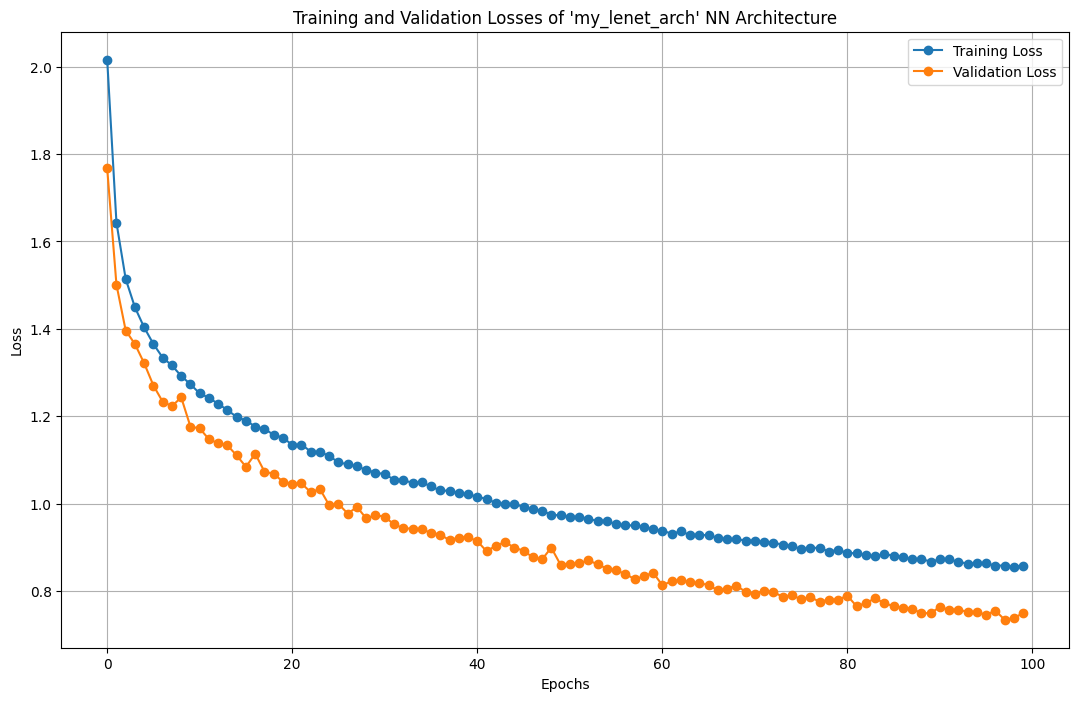

In [64]:
# Plot of the Training and Validation losses

plt.figure(figsize=(13, 8))
plt.title(f"Training and Validation Losses of \'{nn_arch}\' NN Architecture")
plt.plot(train_loss_list, label='Training Loss',   marker='o')
plt.plot(test_loss_list,  label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()

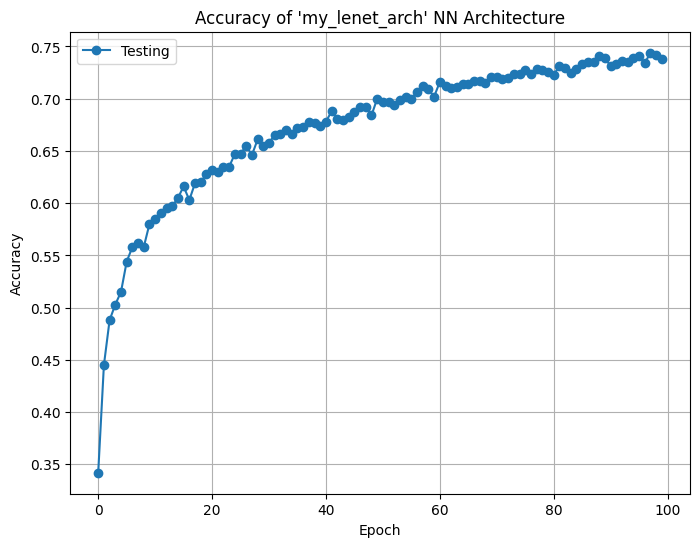

In [65]:
# Plot of the Accuraccy

plt.figure(figsize=(8, 6))
plt.title(f"Accuracy of \'{nn_arch}\' NN Architecture")
plt.plot(accuracy_list, label='Testing', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [66]:
accuracy = 0

# Set the model in evaluation mode
model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
          
        log_ps = model.forward(images)                
        
        # Calculate accuracy
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

print(f"Test accuracy: {(accuracy/len(test_loader))*100:2.1f}%")

Test accuracy: 73.8%


## Saving your model
Using `torch.save`, save your model for future loading.

In [67]:
torch.save({
    'epoch'               : epoch + 1,
    'model_state_dict'    : model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'running_loss_list'   : train_loss_list,
    'accuracy_list'       : accuracy_list,
    'val_loss_list'       : test_loss_list
}, 'checkpoint.pth')

## Make a Recommendation

**Summary and Conclusions**

The the above study was conducted in a few hours on a standard laptop equipped with 64 GB of memory and 8 cores running at 2.4 GHz. 

The results show that a very basic convolutional neural network (CNN) achieves 70% accuracy in just a few tens of epochs. We used a 5-layers CNN architecture inspired by one of the very first Deep Neural Network published in 1998 by *Yann LeCun, Leon Bottou, Yosuha Bengio and Patrick Haffner*, and refered to as *Le-Net-5*. 

Our model reaches **75% accuracy** after 100 epochs while using a learning rate of *0.001* but zero model tuning such as dropout or regularization. 

Therefore, we **highly discourage the buying** of the proposed object detection algorithm claimed at 70% accuracy rate on the CIFAR-10 dataset. Instead, **we recommend investing in a powerfull GPU and few more hours of experimentation** with some more efficient and modern CNN architectectures from the litterature, such as VGG-XX, GoogleNet-vX, ResNet-XX and more.   



